# Siamese Neural Network

In [1]:
import os
import numpy as np
import matplotlib
import random
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision import transforms
from PIL import Image
from matplotlib import pyplot as plt

/home/bakerchen/.conda/envs/ML/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!nvidia-smi

Tue Jun 13 14:56:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 63%   85C    P2    78W / 250W |   3864MiB / 11264MiB |     81%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:82:00.0 Off |                  N/A |
| 35%   

## Configuration

In [3]:
class Config():
    training_dir = "./data/faces/training"
    testing_dir = "./data/faces/testing"
    # training_dir = "./data/EMNIST"
    # testing_dir = "./data/EMNIST"
    model_dir = "./model"
    ratio = 0.8
    batch_size = 8
    epochs = 100
    lr = 1e-4
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    threshold = 0.9

## Helper functions

In [4]:
def imshow(img, title=None, text=None):
    npimg = img.numpy()
    plt.axis("off")
    
    if title:
        plt.title(title, style='italic', fontweight='bold')
        
    if text:
        plt.text(25, 8 , text, style='italic', fontweight='bold', bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration, loss):
    plt.plot(iteration, loss)
    plt.show()

## Custom Dataset

In [5]:
class SiameseDataset(Dataset):
    def __init__(self, imageFolderDataset, transform=None):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform
    
    def __getitem__(self, index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        
        # need to make sure approximate 50% of image are in the same class (balance)
        same_class = random.randint(0,1)
        if same_class:
            while True:
                # keep looping until the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:
            while True:
                # keep looping until the different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] != img1_tuple[1]:
                    break
        
        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [6]:
folder_dataset = datasets.ImageFolder(root=Config.training_dir)

In [7]:
siamese_dataset = SiameseDataset(imageFolderDataset=folder_dataset,
                                 transform=transforms.Compose([transforms.Resize([32,32]),
                                                               # transforms.RandomRotation((-15,15)),
                                                               transforms.ToTensor()]))

In [8]:
train_size = int(Config.ratio * len(siamese_dataset))
test_size = len(siamese_dataset) - train_size

train_dataset, valid_dataset = torch.utils.data.random_split(siamese_dataset, [train_size, test_size])

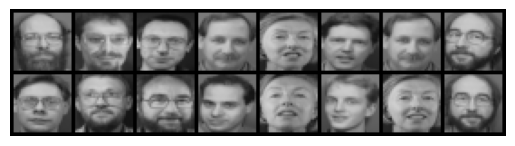

[[1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]]


In [9]:
train_loader = DataLoader(train_dataset,
                          shuffle=True,
                          batch_size=Config.batch_size)

valid_loader = DataLoader(valid_dataset,
                          shuffle=True,
                          batch_size=Config.batch_size)


dataiter = iter(train_loader)
example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]), 0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Siamese Network

In [10]:
class SiameseNetwork(nn.Module):
    """
        Siamese network for image similarity estimation.
        The network is composed of two identical networks, one for each input.
        The output of each network is concatenated and passed to a linear layer. 
        The output of the linear layer passed through a sigmoid function.
    """
    # AlexNet
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.embedding = nn.Sequential(
            nn.Linear(7200, 16)
        )
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.embedding(x)
        x = self.sigmoid(x)
        return x

In [11]:
model = SiameseNetwork().to(Config.device)

In [12]:
print(model)

SiameseNetwork(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (embedding): Sequential(
    (0): Linear(in_features=7200, out_features=16, bias=True)
  )
  (sigmoid): Sigmoid()
)


In [13]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

features.0.weight tensor([[[[-6.8903e-03, -3.2145e-01,  2.6058e-01],
          [-1.0759e-01, -3.2241e-01, -2.8061e-01],
          [-9.1990e-02,  8.4651e-02, -9.7453e-02]]],


        [[[ 5.2520e-02, -2.5234e-01,  2.2293e-01],
          [ 2.2164e-01, -2.8990e-01, -1.2381e-01],
          [ 1.7210e-01,  1.8061e-01, -1.4849e-01]]],


        [[[-1.9463e-01,  5.8239e-02,  1.3800e-01],
          [-3.9127e-02, -2.2331e-01,  6.2220e-02],
          [-2.2861e-01,  1.7789e-01, -1.1989e-01]]],


        [[[-3.0660e-01,  1.7960e-02, -1.1192e-01],
          [ 2.1366e-01,  3.2431e-01, -2.5464e-01],
          [-2.8652e-01, -9.9226e-02,  2.6496e-01]]],


        [[[ 2.7296e-01,  1.6339e-01,  1.3939e-01],
          [-8.2775e-02, -2.1628e-01,  7.6894e-02],
          [-1.8030e-01, -1.7403e-01, -2.6129e-01]]],


        [[[-2.1997e-01,  9.5521e-02, -3.7995e-02],
          [-3.0390e-02, -1.7413e-01, -2.9987e-01],
          [ 1.4832e-01,  2.2836e-01, -3.2391e-03]]],


        [[[-3.2183e-01, -1.1967e-01,  2.

In [14]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    
    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
        loss = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                          (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        
        return loss

## Train Model

In [15]:
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=Config.lr, weight_decay=0.0005)

In [16]:
def train(model, train_loader, valid_loader, num_epochs, criterion):
    train_losses = []
    valid_losses = []
    
    for epoch in range(num_epochs):
        train_running_loss = 0.0
        
        # Training Stage
        for i, data in enumerate(train_loader):
            img1, img2, label = data
            img1, img2, label = img1.to(Config.device), img2.to(Config.device), label.to(Config.device)
            optimizer.zero_grad()
            output1, output2 = model(img1), model(img2)
            
            
            # loss
            loss = criterion(output1, output2, label)
            loss.backward()
            optimizer.step()
            
            train_running_loss += loss.item()
              
        avg_train_loss = train_running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        
        # Validation Stage
        valid_running_loss = 0.0
        valid_correct = 0
        with torch.no_grad():
            model.eval()
            for i, data in enumerate(valid_loader):
                img1, img2, label = data
                img1, img2, label = img1.to(Config.device), img2.to(Config.device), label.to(Config.device)
                output1, output2 = model(img1), model(img2)
                
                # loss
                loss = criterion(output1, output2, label)
                valid_running_loss += loss.item()
                
            avg_valid_loss = valid_running_loss / len(valid_loader)
            valid_losses.append(avg_valid_loss)
            
                
                
        print("Epoch [{}/{}]: Train Loss: {:.4f}, Valid Loss: {:.4f}"
              .format(epoch+1, num_epochs, avg_train_loss, avg_valid_loss))
        
        # Save model
        torch.save(model.state_dict(), os.path.join(Config.model_dir, "model_epoch{}.pth".format(epoch)))
        
    print("Finished Training")
    
    return train_losses, valid_losses

In [17]:
train_losses, valid_losses = train(model, train_loader, valid_loader, Config.epochs, criterion)

Epoch [1/100]: Train Loss: 1.8544, Valid Loss: 1.8643
Epoch [2/100]: Train Loss: 1.5365, Valid Loss: 1.1943
Epoch [3/100]: Train Loss: 1.2961, Valid Loss: 0.9300
Epoch [4/100]: Train Loss: 0.9092, Valid Loss: 0.8268
Epoch [5/100]: Train Loss: 0.7577, Valid Loss: 0.8551
Epoch [6/100]: Train Loss: 0.7049, Valid Loss: 0.6421
Epoch [7/100]: Train Loss: 0.5943, Valid Loss: 0.7629
Epoch [8/100]: Train Loss: 0.5633, Valid Loss: 0.4679
Epoch [9/100]: Train Loss: 0.5084, Valid Loss: 0.5147
Epoch [10/100]: Train Loss: 0.5088, Valid Loss: 0.4502
Epoch [11/100]: Train Loss: 0.5691, Valid Loss: 0.5594
Epoch [12/100]: Train Loss: 0.5257, Valid Loss: 0.4260
Epoch [13/100]: Train Loss: 0.4640, Valid Loss: 0.3979
Epoch [14/100]: Train Loss: 0.4409, Valid Loss: 0.4091
Epoch [15/100]: Train Loss: 0.4498, Valid Loss: 0.3623
Epoch [16/100]: Train Loss: 0.4224, Valid Loss: 0.4423
Epoch [17/100]: Train Loss: 0.3958, Valid Loss: 0.3338
Epoch [18/100]: Train Loss: 0.4104, Valid Loss: 0.5894
Epoch [19/100]: Tra

## Plot losses

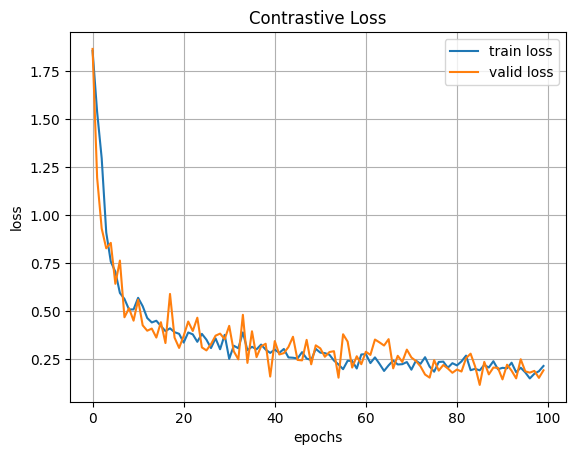

<Figure size 640x480 with 0 Axes>

In [26]:
plt.figure()
plt.plot(train_losses, label="train loss")
plt.plot(valid_losses, label="valid loss")
plt.title("Contrastive Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.savefig('./result/loss.png')
plt.show()
plt.close()

In [19]:
folder_dataset_test = datasets.ImageFolder(root=Config.testing_dir)

siamese_dataset = SiameseDataset(imageFolderDataset=folder_dataset,
                                 transform=transforms.Compose([transforms.Resize([32,32]),
                                                               transforms.ToTensor()]))

## Testing

In [20]:
test_dataloader = DataLoader(siamese_dataset, batch_size=1, shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

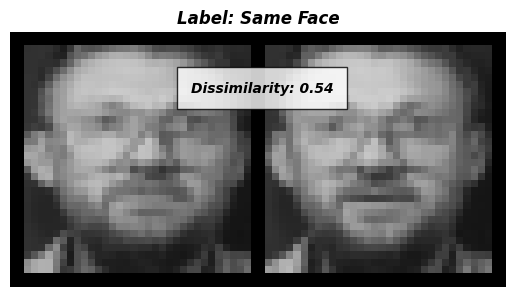

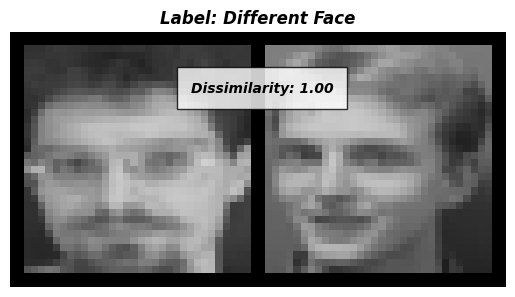

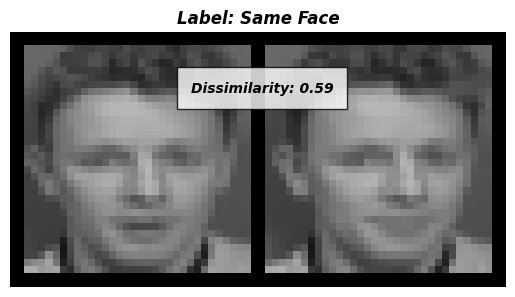

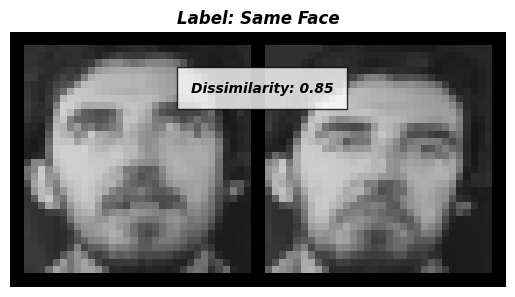

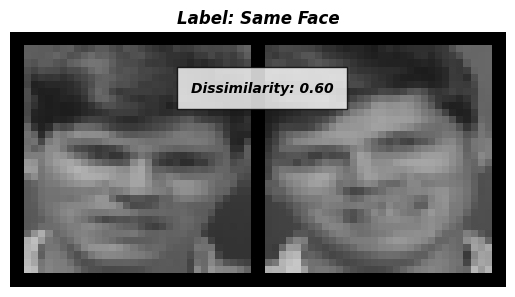

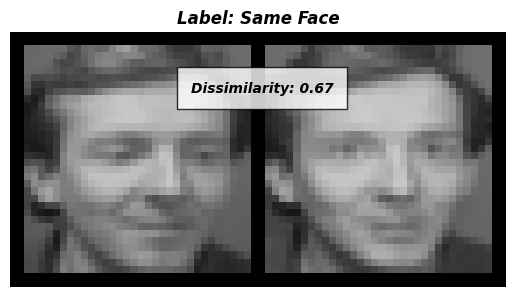

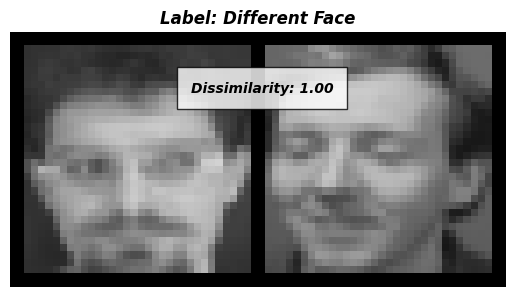

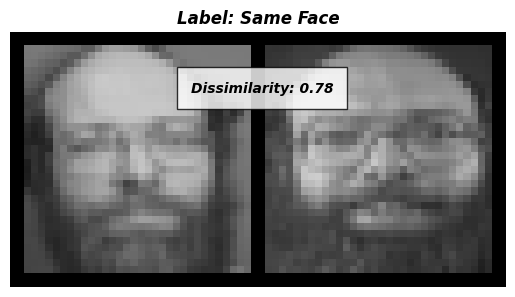

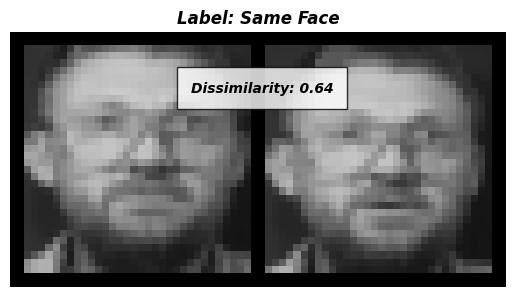

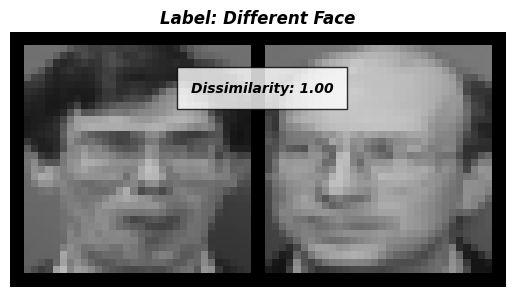

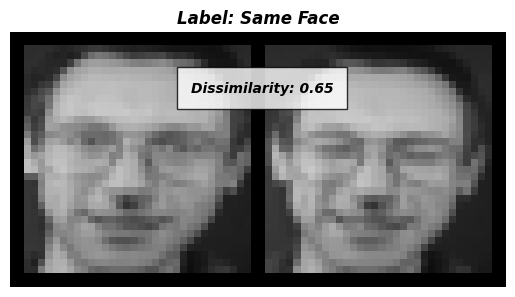

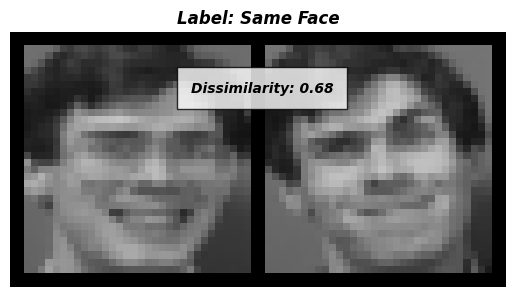

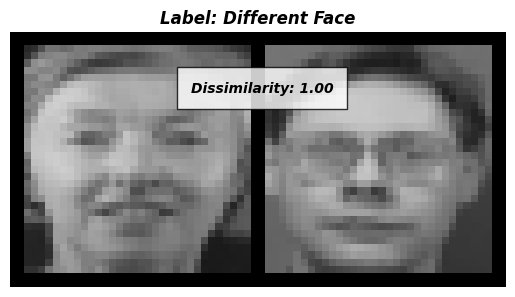

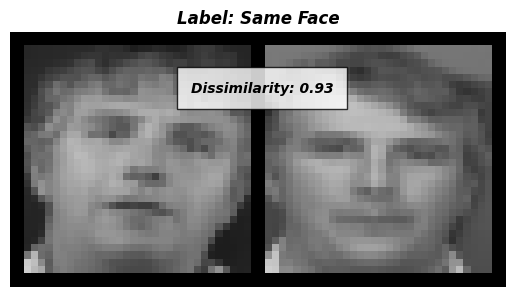

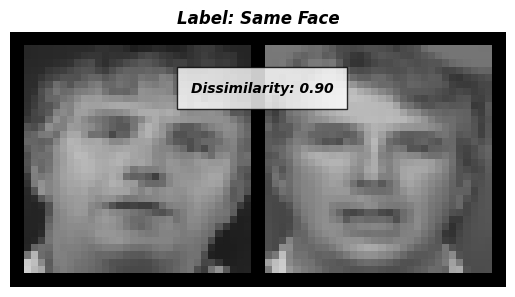

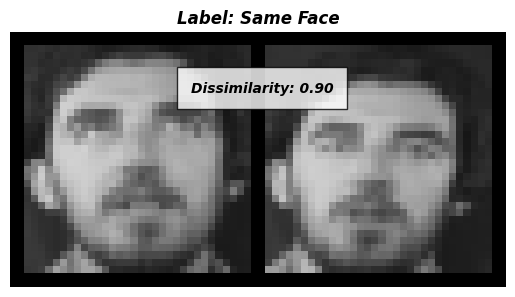

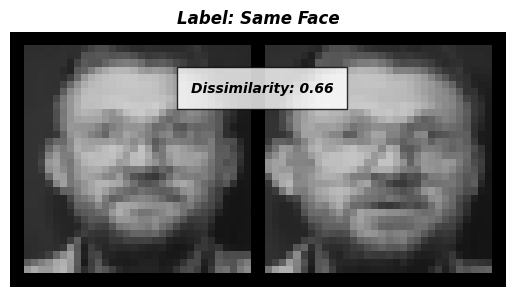

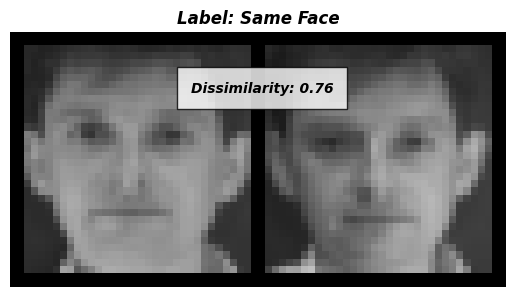

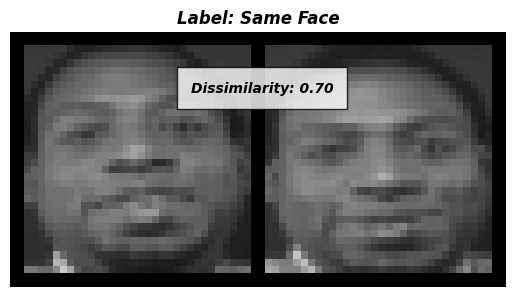

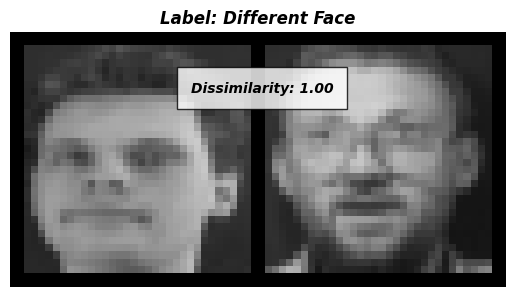

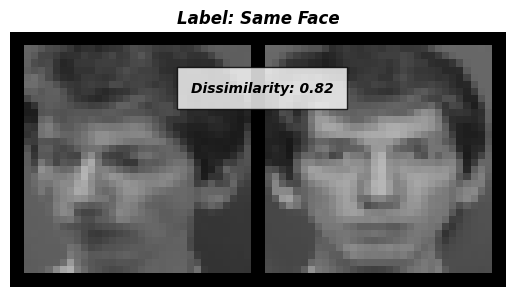

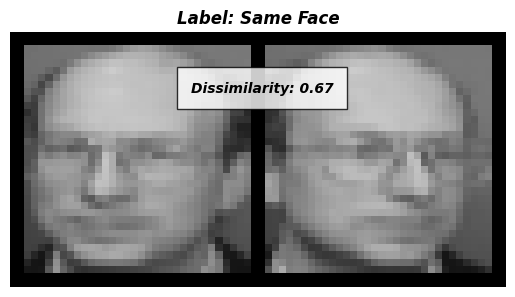

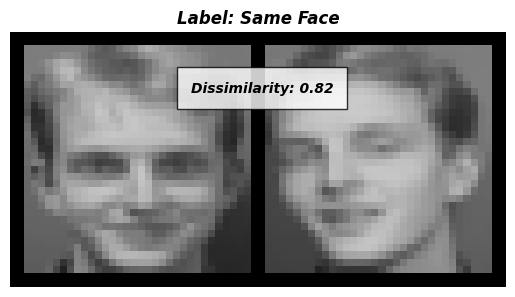

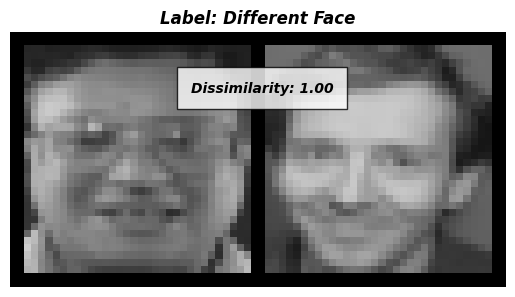

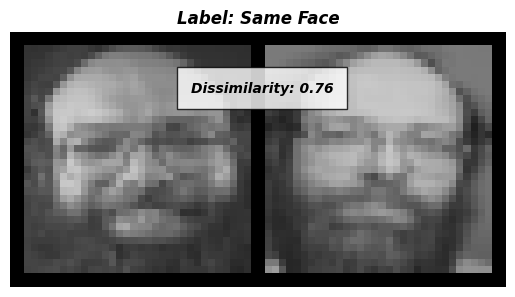

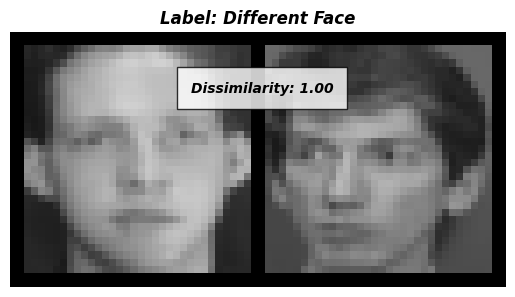

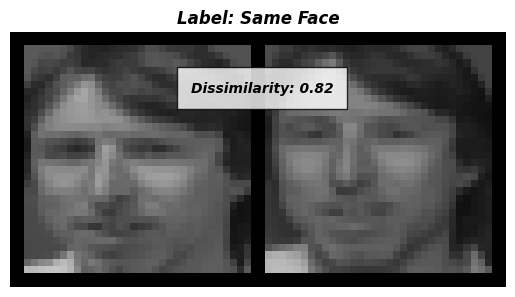

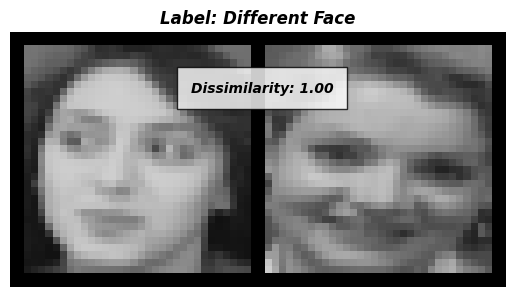

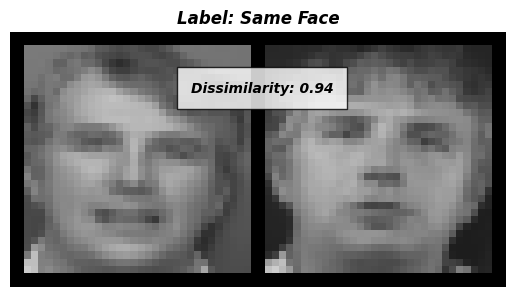

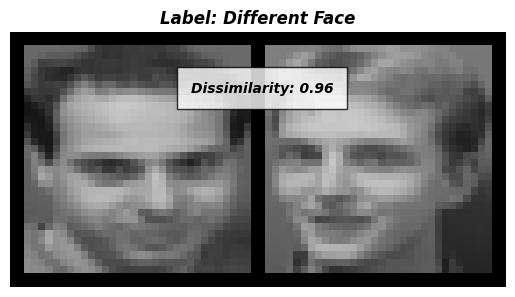

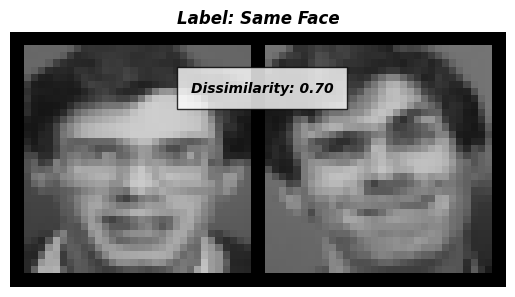

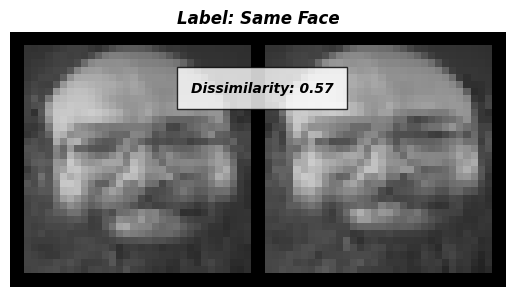

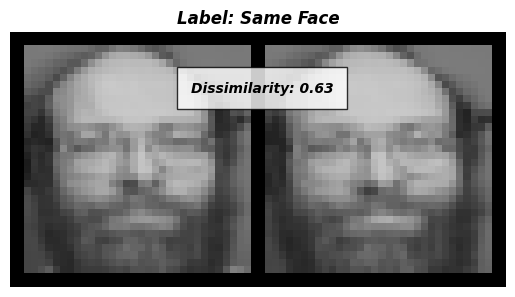

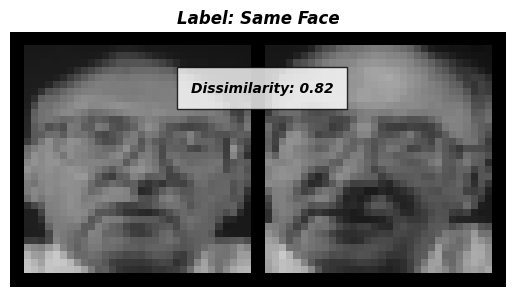

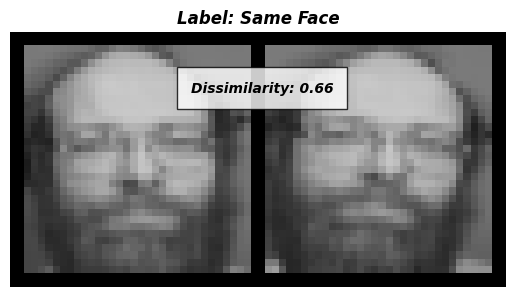

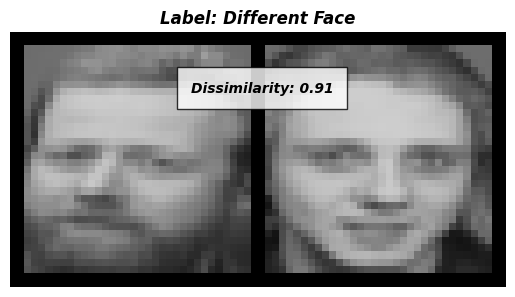

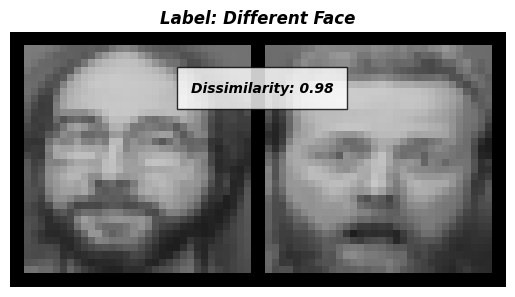

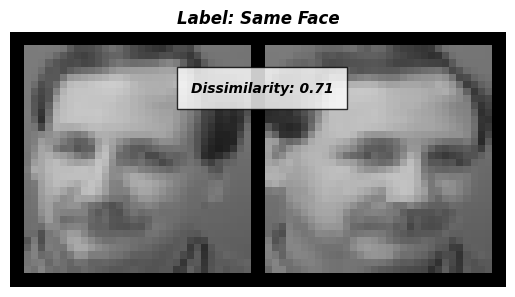

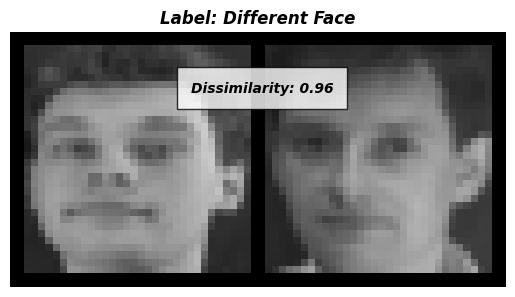

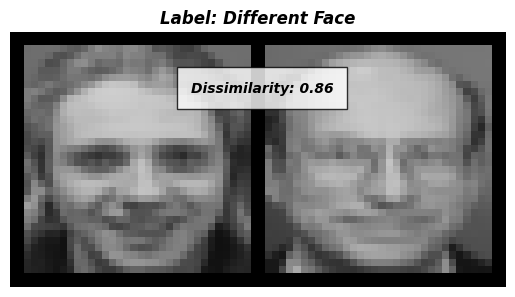

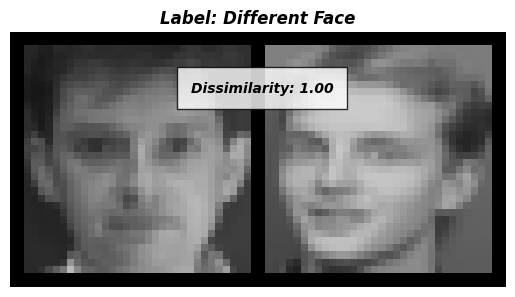

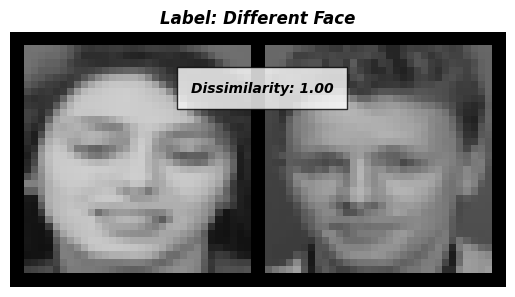

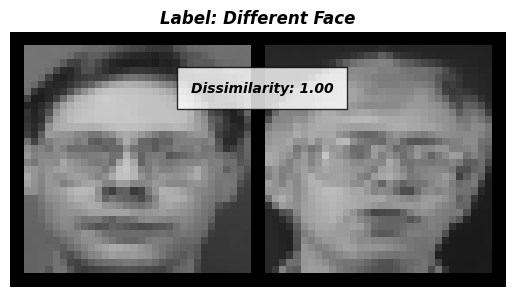

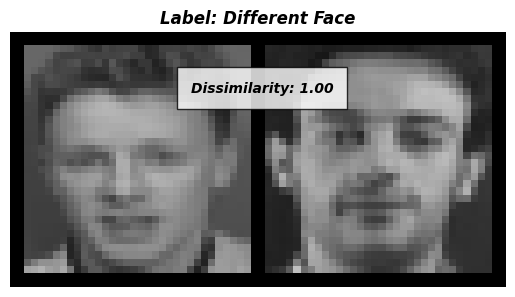

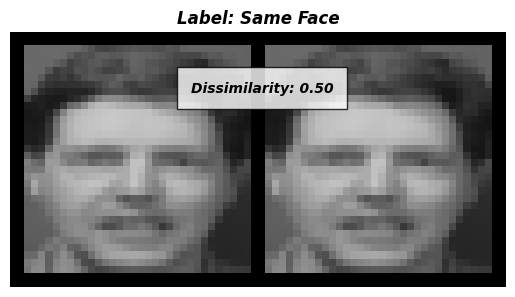

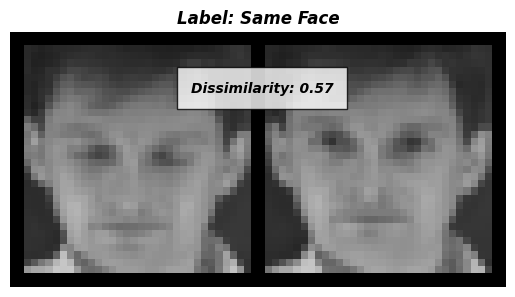

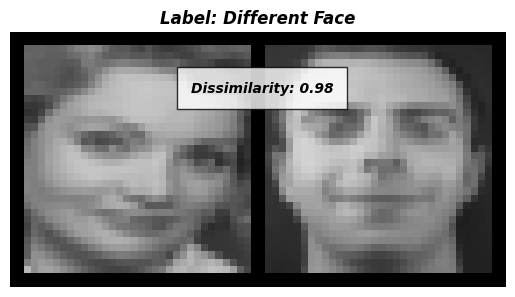

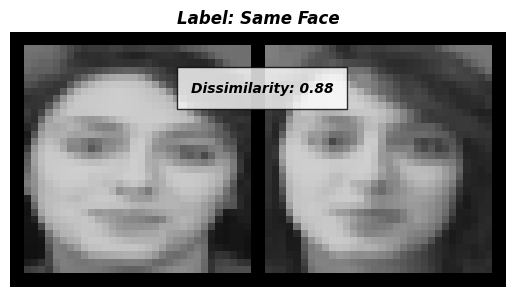

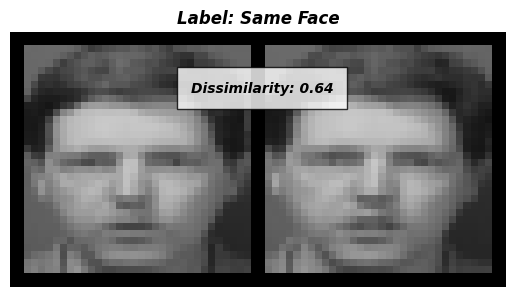

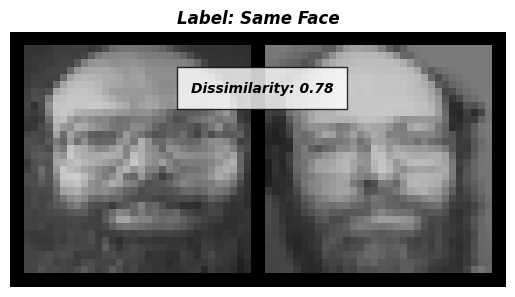

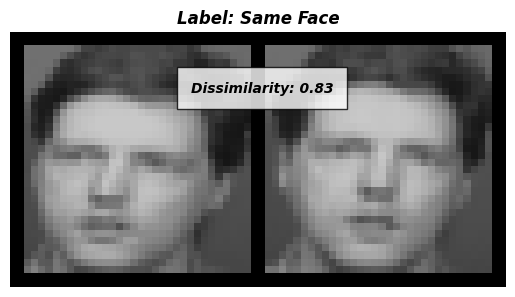

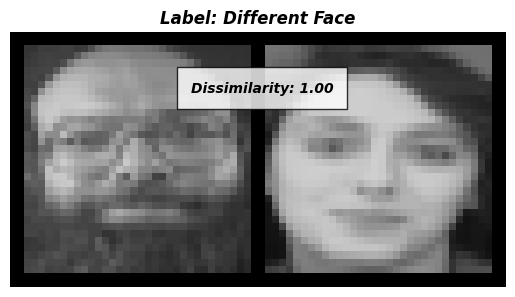

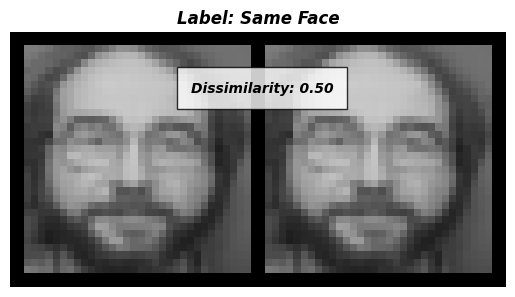

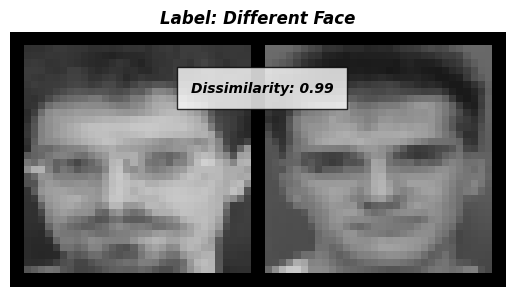

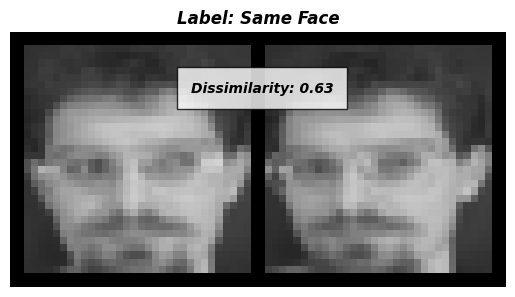

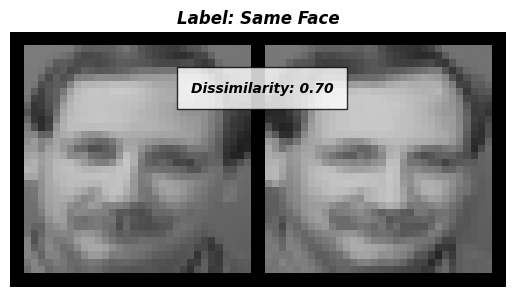

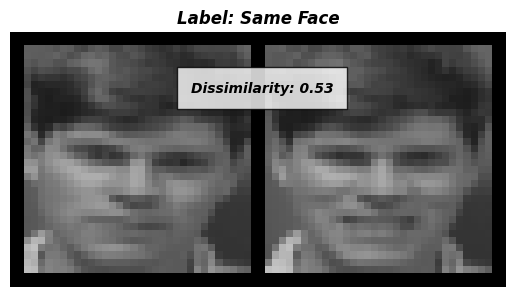

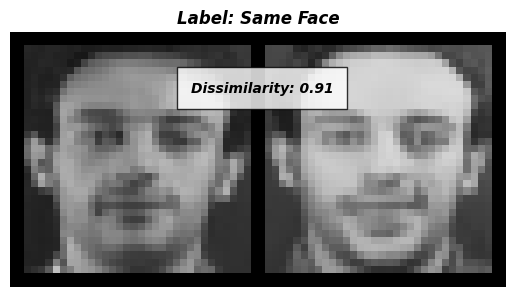

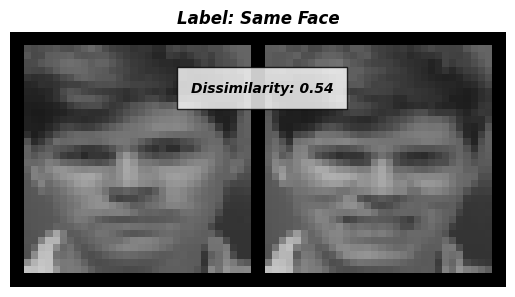

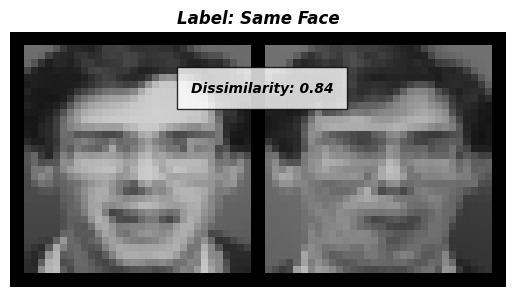

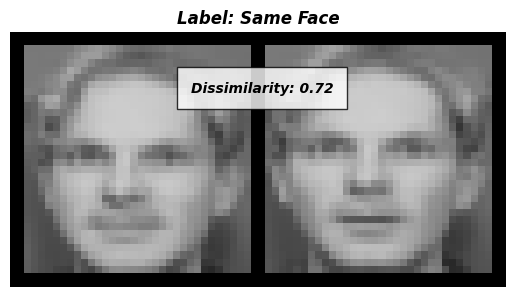

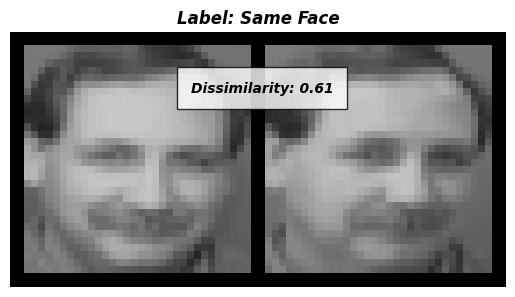

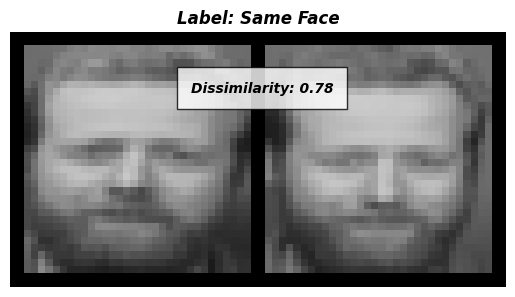

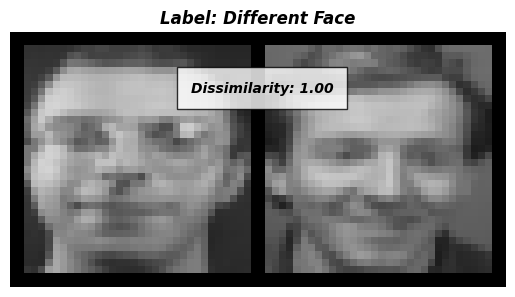

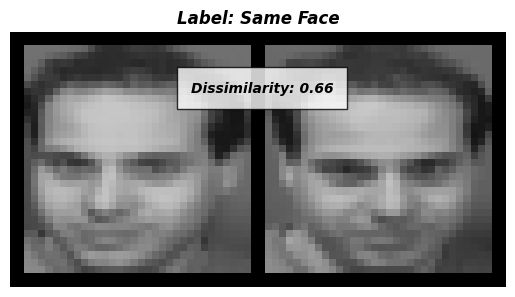

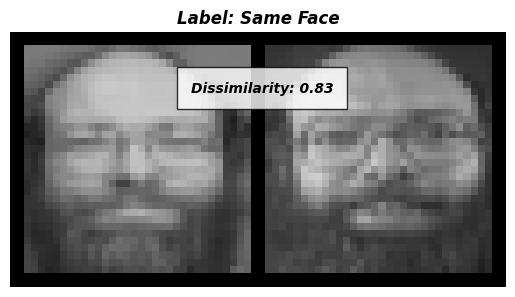

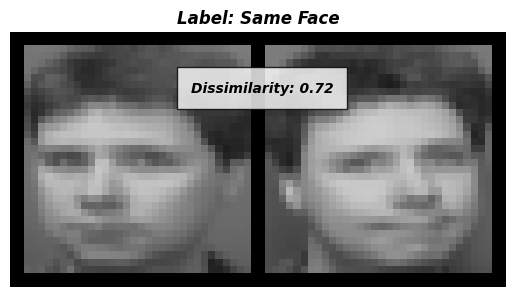

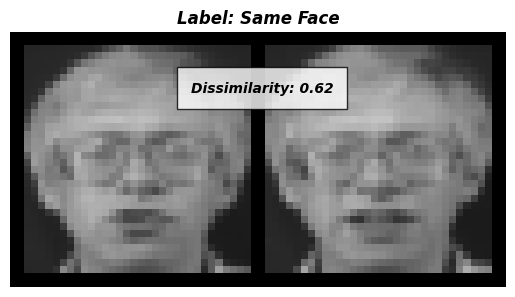

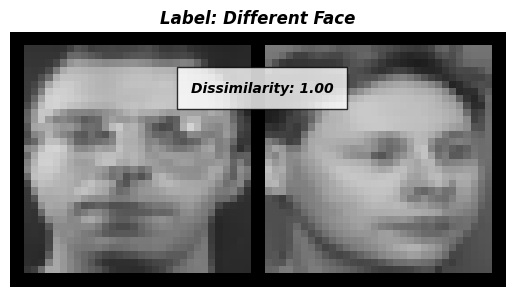

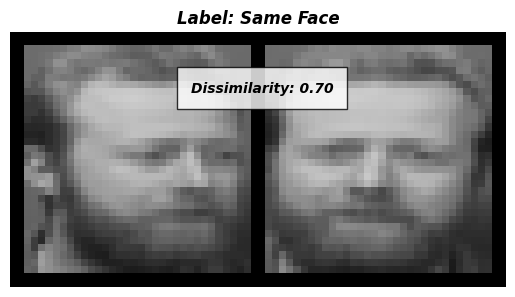

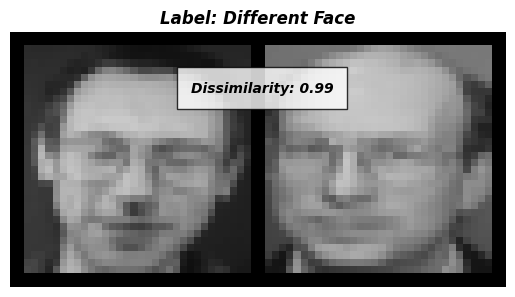

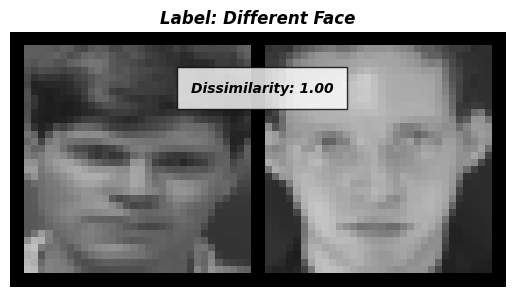

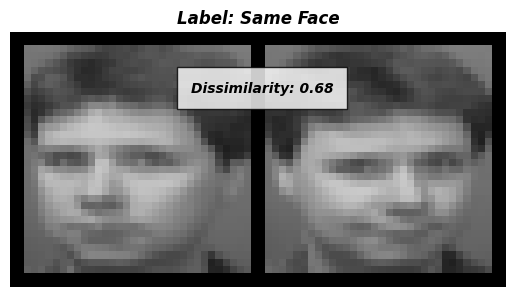

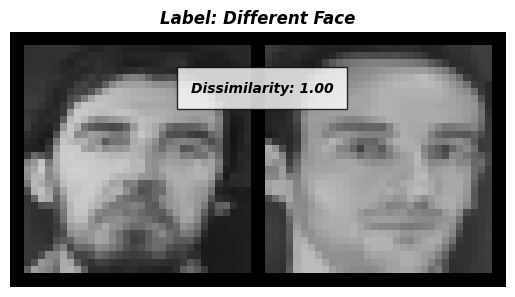

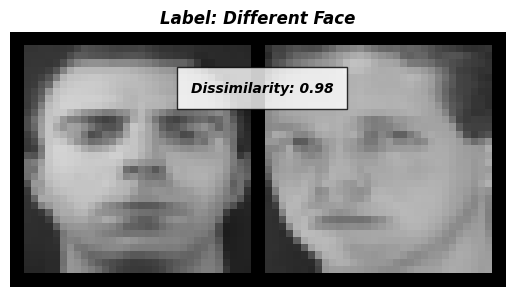

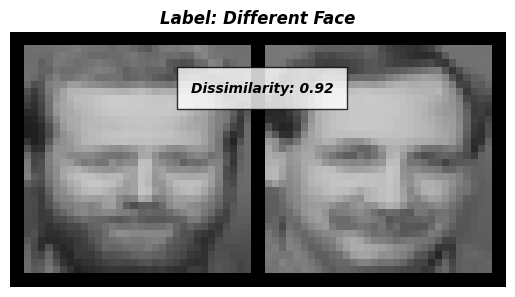

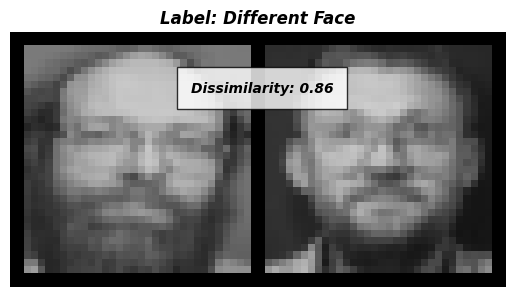

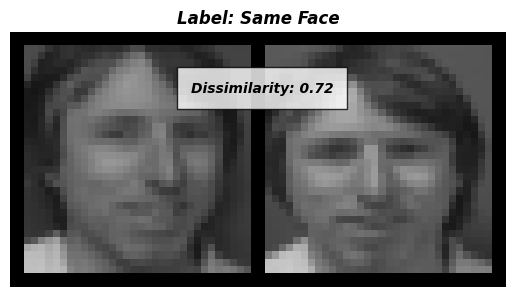

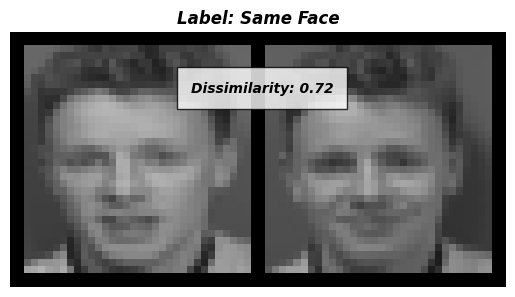

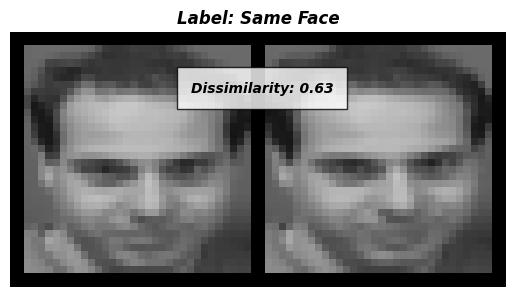

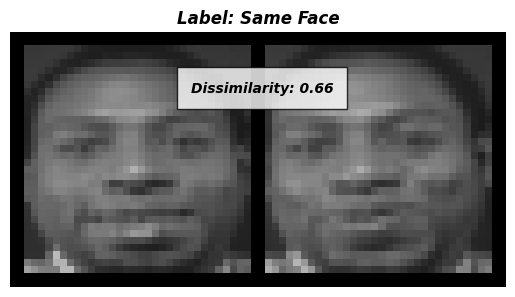

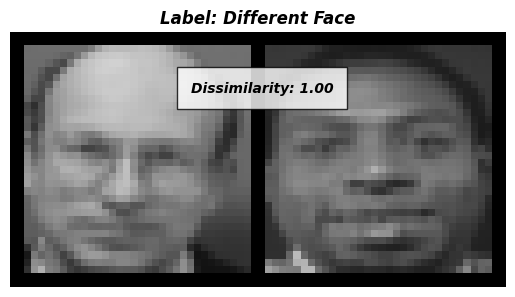

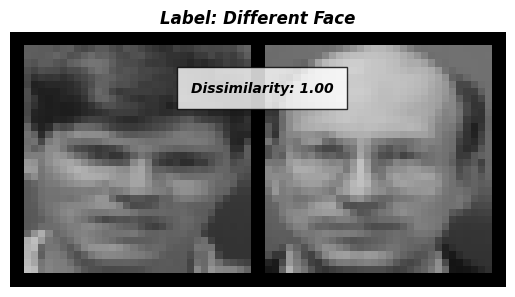

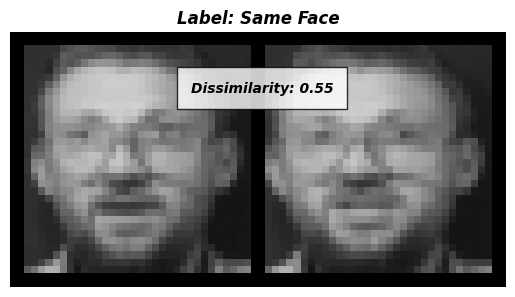

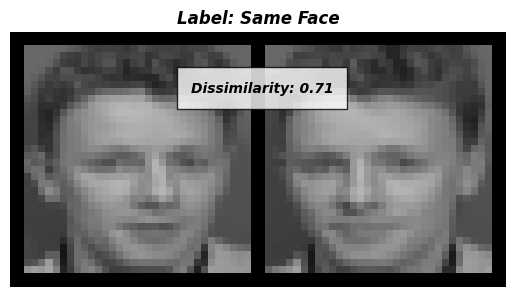

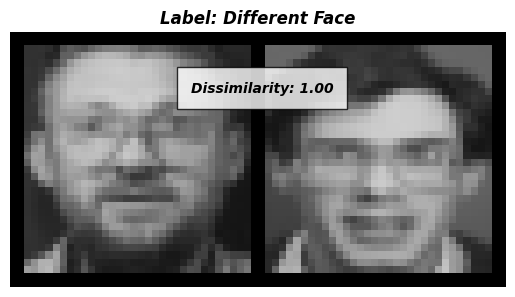

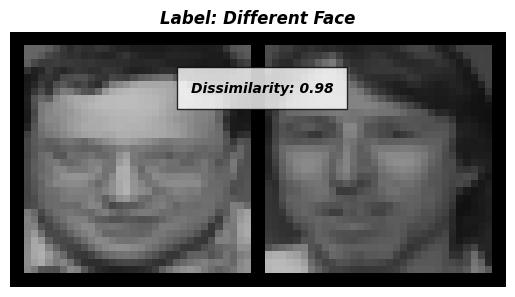

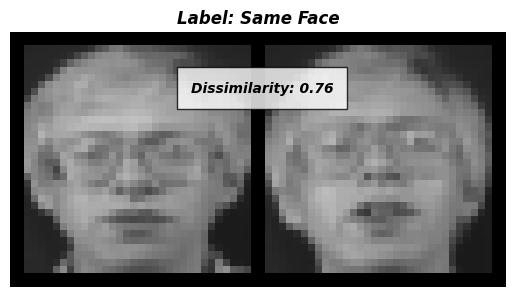

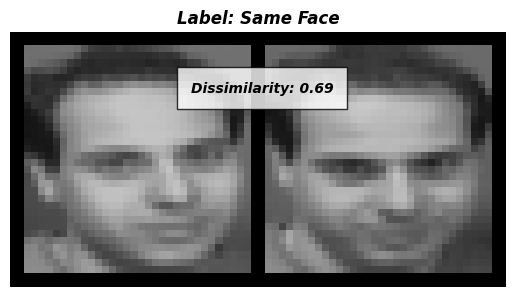

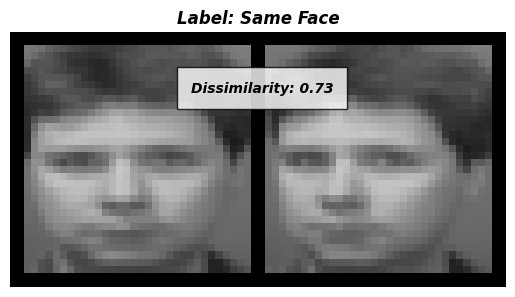

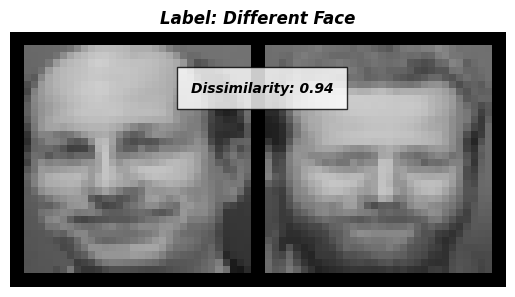

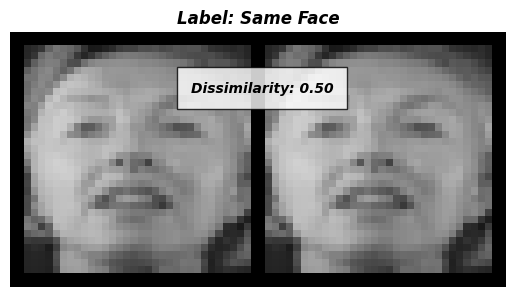

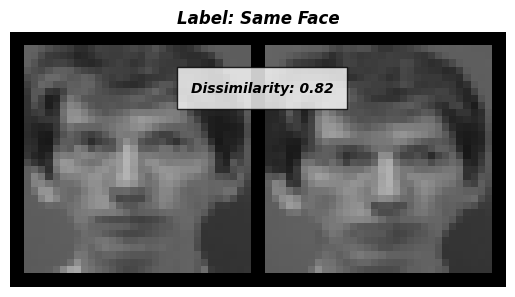

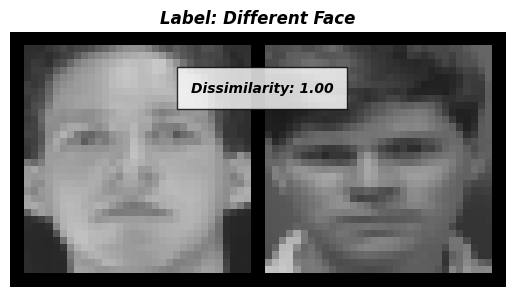

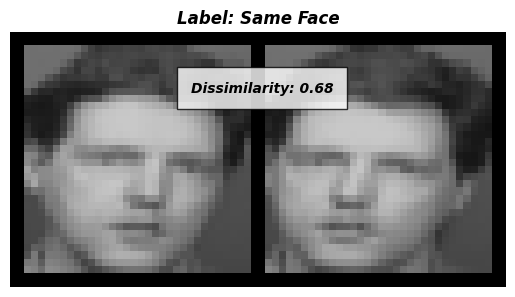

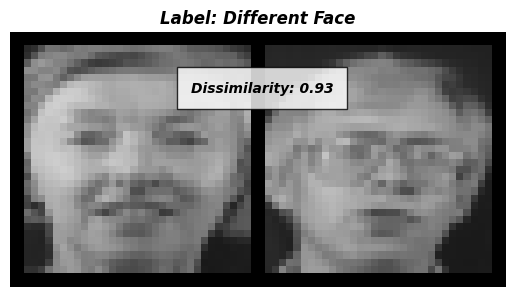

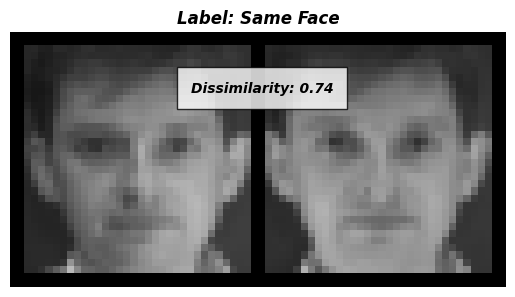

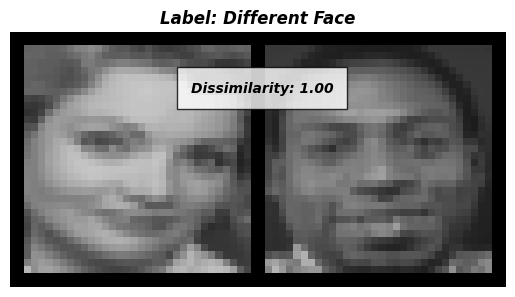

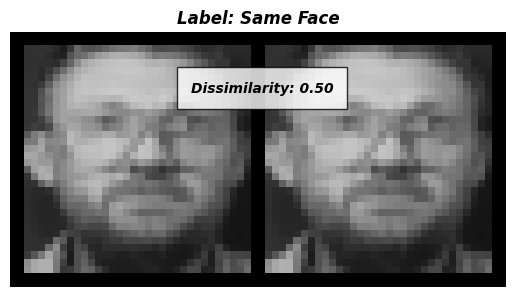

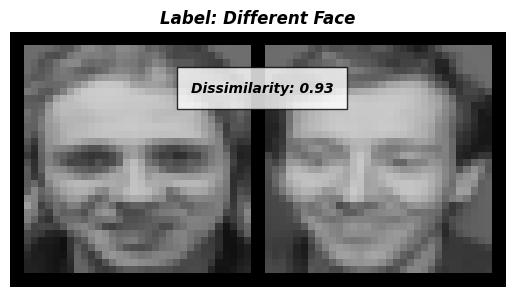

In [21]:
test_num = 100
correct = 0
for i in range(test_num):
    x1 , x2, label = next(dataiter)
    concatenated = torch.cat((x1,x2),0)
    
    output1 = model(x1.to(Config.device))
    output2 = model(x2.to(Config.device))
    # euclidean_distance = F.pairwise_distance(output1, output2)
    euclidean_distance = F.pairwise_distance(output1, output2, p=1)
    m = nn.Sigmoid()
    score = m(euclidean_distance)
    
    # print("output1: ", output1)
    # print("output2: ", output2)
    
    if score > Config.threshold:
        pred = 1
    else:
        pred = 0
    
    if label.numpy().squeeze() == 0:
        label_str = 'Same Face'
        label = 0
    else:
        label_str = 'Different Face'
        label = 1
        
    # cumulate correct
    if pred == label:
        correct+=1

    
    # show figure
    imshow(torchvision.utils.make_grid(concatenated), 'Label: ' + label_str, 'Dissimilarity: {:.2f}'.format(score.item()))
    
    # plot figure
    grid_image = torchvision.utils.make_grid(concatenated)
    plt.figure()
    plt.imshow(grid_image.permute(1, 2, 0))
    plt.title('Label: ' + label_str + ', Dissimilarity: {:.2f}'.format(score.item()))
    plt.axis('off')
    plt.savefig('./result/test'+str(i)+'.png')
    plt.close()
    
    # save .txt
    x1_list = list(np.array(x1.flatten()))
    x2_list = list(np.array(x2.flatten()))
    with open('./images/image' + str(i) +'.txt', 'w') as fp:
        for x in x1_list:
            fp.write(str(x))
            fp.write("\n")
        
        for x in x2_list:
            fp.write(str(x))
            fp.write("\n")
            

In [22]:
# Calculate accuracy
acc = correct / test_num
print("accuracy: ", acc)

accuracy:  0.94


## Convert .pth to .txt

In [23]:
path = "./model/model_epoch99.pth"
torch.set_printoptions(threshold=np.inf)

model = torch.load(path, map_location='cpu')
string = str(model)

# original .pth to .txt
with open('./weight/weight_pth.txt', 'w') as fp:
    fp.write(string)


weights = []

for i in model.keys():
    print(i)
    
for i in model.keys():
    weights.extend(list(np.array(model[i]).flatten()))
    print(len(list(np.array(model[i]).flatten())))

# write weights to .txt
with open('./weight/weight.txt', 'w') as fp:
    for w in weights:
        fp.write(str(w))
        fp.write("\n")

features.0.weight
features.0.bias
embedding.0.weight
embedding.0.bias
288
32
115200
16
